In [1]:
from google.colab import files
upload = files.upload()

Saving twitter-archive-enhanced.csv to twitter-archive-enhanced.csv


In [2]:
from google.colab import files
upload = files.upload()

Saving tweet-json.txt to tweet-json.txt


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer

##1-Gathering Data
1-Twitter archive file: download this file manually by clicking the following link: twitter_archive_enhanced.csv



In [4]:
archive_df = pd.read_csv("twitter-archive-enhanced.csv")

In [5]:
archive_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [10]:
archive_df.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

2- The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) is hosted on Udacity's servers and should be downloaded programmatically using the Requests library and the following URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

In [5]:
#request url using response library and confirm if its successful
url =  'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)
response

<Response [200]>

In [6]:
#Open url using file format and split it ti only retain 'image-predictions.tsv and then write it into a file named image
with open(url.split('/')[-1], 'wb') as image :
  image.write(response.content)

In [7]:
#Read tsv file using pandas and create a dataframe
df_imgpred = pd.read_csv('image-predictions.tsv', sep='\t')

In [ ]:
#Programmatically download the dataframe to local machine
from google.colab import files
files.download("image-predictions.tsv")

In [ ]:
df_imgpred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


3.Twitter API & JSON: Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count.

Below is the API querying code which would have been used if i had elevated access

In [ ]:

# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO STUDENT WITH MOBILE VERIFICATION ISSUES:
# df_1 is a DataFrame with the twitter_archive_enhanced.csv file. You may have to
# change line 17 to match the name of your DataFrame with twitter_archive_enhanced.csv
# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()
print(end - start)
print(fails_dict)

But i wasnt able to get elevated access to tweepy so i used the tweet-json.txt file already provided in the lesson and read it into a pandas dataframe with its unique encoding.

In [9]:
#Open json file and use it to create a dataframe
with open('tweet-json.txt') as file :
  tweet_df = pd.read_json(file, lines=True, encoding='utf-8')

In [28]:
tweet_df.head(1)

,created_at,id,id_str,full_text,truncated,display_text_range,entities,extended_entities,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,possibly_sensitive,possibly_sensitive_appealable,lang,retweeted_status,quoted_status_id,quoted_status_id_str,quoted_status
0,2017-08-01 16:23:56+00:00,892420643555336193,892420643555336192,This is Phineas. He's a mystical boy. Only eve...,False,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,39467,False,False,0.0,0.0,en,NaN,NaN,NaN,NaN


The only thing needed from this dataframe is the tweet id, retweet count and favorite count so we would extract that  

In [28]:
tweet_df.columns

Index(['created_at', 'id', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status'],
      dtype='object')

In [10]:
df_tweet = tweet_df.drop(['created_at', 'id_str', 'full_text', 'truncated',
       'display_text_range', 'entities', 'extended_entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status',
       'favorited', 'retweeted', 'possibly_sensitive',
       'possibly_sensitive_appealable', 'lang', 'retweeted_status',
       'quoted_status_id', 'quoted_status_id_str', 'quoted_status'], axis = 1)

df_tweet

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


## 2 - Assessing the Data

Visual Assessment

In [11]:
archive_df

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None



- The timestamp column has dates in object datatype.
- Some of the rows have invalid strings in the name column, e.g. "a" which is  part of the words in the tweet.
- "None" values in the name column.

In [32]:
df_imgpred

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


- The Predictions start with both uppercase and lowercase 
- The img_num column is not important 

In [12]:
df_tweet

,id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048
...,...,...,...
2349,666049248165822465,41,111
2350,666044226329800704,147,311
2351,666033412701032449,47,128
2352,666029285002620928,48,132


#Programmatic assessment

- Archive dataset

In [34]:
archive_df.shape

(2356, 17)

In [ ]:
archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

The info assessment reveals a few issues

- There are 2297 tweets with expanded_urls (images links) indicating 59 tweets with missing data
- There are 181 retweets (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) and the columns related to retweets are not applicable for original tweets
- There are 78 replies (in_reply_to_status_id, in_reply_to_user_id) and the columns related to replies are not applicable for original tweets
- The timestamp field is in string format (object)
- There are 4 columns for dog stages (doggo, floofer, pupper, puppo)


In [35]:
archive_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
sum(archive_df.duplicated())

0

In [22]:
# Referring to the quality issue with the name, lets check the value counts for the column
archive_df.name.value_counts().head(50)

None        745
a            55
Charlie      12
Cooper       11
Lucy         11
Oliver       11
Tucker       10
Penny        10
Lola         10
Winston       9
Bo            9
Sadie         8
the           8
Daisy         7
Buddy         7
Toby          7
an            7
Bailey        7
Leo           6
Oscar         6
Stanley       6
Rusty         6
Bella         6
Dave          6
Jack          6
Koda          6
Scout         6
Jax           6
Milo          6
Louis         5
Phil          5
Sammy         5
Gus           5
Chester       5
Alfie         5
Sunny         5
Bentley       5
very          5
Oakley        5
Finn          5
George        5
Larry         5
Clarence      4
Loki          4
Walter        4
Reggie        4
Hank          4
Scooter       4
Duke          4
quite         4
Name: name, dtype: int64

This reveals there are more names other than "a" and 'None' we discovered during the visual assessment as "an", 'very' , 'quite', 'the' do not look like valid dog names even though its a possibility.

There are 745 dog names with "None" but this would be left as it is as it is too many to exclude from dataset

It also looks like the dog names are all capitalized, so words that begin in lowercase are probably not names, like "a", "the" and "an". 
A list of these "names" is provided below

In [46]:
#All lower case names
lower_names = archive_df.name.str.contains('^[a-z]', regex = True)
archive_df[lower_names].name.value_counts().sort_index()

a               55
actually         2
all              1
an               7
by               1
getting          2
his              1
incredibly       1
infuriating      1
just             4
life             1
light            1
mad              2
my               1
not              2
officially       1
old              1
one              4
quite            4
space            1
such             1
the              8
this             1
unacceptable     1
very             5
Name: name, dtype: int64

In [24]:
len(archive_df[lower_names])

109

There are 109 names in the dataset which are not capitalized and do not look like valid names

In [29]:
archive_df.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [30]:
archive_df.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [31]:
archive_df.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [32]:
archive_df.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [33]:
archive_df.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [34]:
archive_df.sample()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1589,686683045143953408,NaN,NaN,2016-01-11 22:56:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mona. She's a Yarborough Splishnsplash...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/686683045...,11,10,Mona,None,None,pupper,None


- Predictions Dataset

In [35]:
df_imgpred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [42]:
df_imgpred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [103]:
df_imgpred.jpg_url.duplicated().sum()

66

There are 66 duplicated image urls

In [36]:
df_imgpred.p1_dog.value_counts()

True     1532
False     543
Name: p1_dog, dtype: int64

In [37]:
df_imgpred.p2_dog.value_counts()

True     1553
False     522
Name: p2_dog, dtype: int64

In [38]:
df_imgpred.p3_dog.value_counts()

True     1499
False     576
Name: p3_dog, dtype: int64

In [39]:
df_imgpred.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

- Tweet Json Dataset

In [40]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


In [43]:
df_tweet.describe()

,id,retweet_count,favorite_count
count,2.354000e+03,2354.000000,2354.000000
mean,7.426978e+17,3164.797366,8080.968564
std,6.852812e+16,5284.770364,11814.771334
min,6.660209e+17,0.000000,0.000000
25%,6.783975e+17,624.500000,1415.000000
50%,7.194596e+17,1473.500000,3603.500000
75%,7.993058e+17,3652.000000,10122.250000
max,8.924206e+17,79515.000000,132810.000000


# Summary of Asessment

##Quality issues

- Numerator and Denominator values are not standardized 
- Source in the archive dataset is too long, it can be shortened to the devices only
- Retweet columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp.181 in total) contain a lot of missing data and is not needed in the analysis so both rows and columns would be dropped
- Reply columns (in_reply_to_status_id, in_reply_to_user_id. 78 in total ) contain a lot of missing data and is not needed in the analysis
- Timestamp Column is in object/ string format
- The expanded_urls column contains some missing data so should be dropped
- The Name Column contains some invalid names that begin with lowercase letters (109 in total). They would be dropped
- The Name column also contains 745 dog names with "None" but this would be left as it is as there are too many to try and verify
- The dog names and predictions are not consistent as not all begin with capital letters
- There are 2075 image predictions, 281 less than the number of tweets in the archive, so will be regarded as missing data
- There are duplicated image urls in the image prediction dataset

##Tidiness Issues

- The dog columns; doggo, floofer, pupper and puppo can fit in one column
- The data gotten from the json file can be combined with the archives dataset


#Cleaning the Data


In [13]:
#Make Copies of datasets
clean_archive = archive_df.copy()
clean_imgpred = df_imgpred.copy()
clean_tweets =  df_tweet.copy()

In [35]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

The info method above shows how the data is just before its been cleaned

##Define

Standardize the numerator and denominator values. 
 
Drop numerators > 15 and denominators not equals to 10

Drop rating_denominator 

Rename rating_numerator column to rating

##Code

In [26]:
# display denominators
clean_archive.rating_denominator.value_counts().sort_index(ascending = False)

150       1
120       1
110       1
90        1
80        2
70        1
50        2
40        1
20        1
11        2
10     1979
7         1
Name: rating_denominator, dtype: int64

In [29]:
#display numerators greater than 15
mask = clean_archive.rating_numerator >= 15
clean_archive[mask].rating_numerator.value_counts().sort_index(ascending = False)

1776    1
420     1
75      1
27      1
26      1
Name: rating_numerator, dtype: int64

In [27]:
#Only denominators with records of 10
clean_archive = clean_archive[clean_archive.rating_denominator == 10]

In [30]:
#Numerators of less than 15 only
clean_archive = clean_archive[clean_archive.rating_numerator < 15]

In [32]:
#Drop denominator column and rename numerator to ratings
clean_archive.drop(['rating_denominator'], axis = 1, inplace = True)
clean_archive.rename(index = str, columns = {'rating_numerator': 'rating'}, inplace = True)

##Test

In [28]:
clean_archive.rating_denominator.value_counts().sort_index(ascending = False)

10    1979
Name: rating_denominator, dtype: int64

In [31]:
clean_archive.rating_numerator.value_counts().sort_index(ascending = False)

14     34
13    280
12    471
11    397
10    413
9     138
8      91
7      45
6      30
5      33
4      12
3      18
2       7
1       4
0       1
Name: rating_numerator, dtype: int64

In [33]:
list(clean_archive)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'rating',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

##Define
- The archive dataset shows source as urls. Extract the source from between the urls


###Code

In [179]:
clean_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [34]:
list_source = ['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
                '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
              '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
              '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>']

new_source = ['Twitter for iPhone', 'Vine - Make a Scene', 'Twitter Web Client', 'TweetDeck']

#we want to change the list_source list to the new_source list

In [35]:
clean_archive.source.replace(list_source, new_source, inplace =True)
#Replaces the initial list with the second list

##Test

In [31]:
clean_archive.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

###Define

Drop all rows containing retweets where the columns will be non-null in these columns, retweeted_status_id, retweeted_status_user_id and retweeted_status_timestamp.

###Code

In [16]:
clean_archive = clean_archive[clean_archive.retweeted_status_id.isna()]

##Test

In [43]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

##Define
Drop all rows that are replies, those that have non-null values in these columns : in_reply_to_status_id and in_reply_to_user_id.

##Code

In [17]:
clean_archive = clean_archive[clean_archive.in_reply_to_status_id.isna()]

##Test

In [48]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

##Define

Drop all columns related to retweets and replies

##Code

In [18]:
columnstodrop = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp','in_reply_to_status_id', 'in_reply_to_user_id']
clean_archive.drop(columnstodrop, axis=1 , inplace = True)
#drop the selected columns

###Test

In [50]:
list(clean_archive)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

##Define
Change timestamp from object to datetime 

##Code

In [19]:
#Convert timestamp to datetime
clean_archive['timestamp'] = pd.to_datetime(clean_archive.timestamp)

##Test

In [52]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   int64              
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   doggo               2097 non-null   object             
 9   floofer             2097 non-null   object             
 10  pupper              2097 non-null   object             
 11  puppo               2097 non-null   object             
dtypes: datetime64[ns, UTC](1), int64(3

##Define
The expanded_urls column contains some missing data so should be dropped since it is not needed

##Code

In [20]:
clean_archive.drop('expanded_urls', axis=1, inplace =True)

##Test

In [54]:
list(clean_archive)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

##Define 
its been established earlier in the assessment that the names in the name column that start with lowercase are not valid names so they would all be replaced with nan and then dropped.

Change name None to Noname to ease understanding

##Code

In [21]:
lower_names = clean_archive.name.str.contains('^[a-z]', regex = True)
#Extracts all the lowercase names and puts then inside the lower_names variable

In [22]:
# All the entries would be changed to nan
clean_archive.loc[lower_names, 'name'] = 'nan'

In [23]:
#Drops all values with nan
clean_archive.drop(clean_archive.query("name == 'nan'").index, inplace=True)

In [24]:
#change 'None' to Nan 
for i in clean_archive['name'] :
  if i == "None":
    clean_archive['name'] = clean_archive['name'].replace('None', np.nan)

##Test

In [25]:
clean_archive.name.value_counts()

Charlie       11
Lucy          11
Oliver        10
Cooper        10
Penny          9
              ..
Shelby         1
Sephie         1
Bonaparte      1
Wishes         1
Christoper     1
Name: name, Length: 929, dtype: int64

##Define
Capitalize all the dog names and prediction names to help with consistency

##Code


In [36]:
##Capitalize first letter by using Capitalize method
clean_archive['name'] = clean_archive.name.str.capitalize()
clean_imgpred['p1']=clean_imgpred.p1.str.capitalize()
clean_imgpred['p2']=clean_imgpred.p2.str.capitalize()
clean_imgpred['p3']=clean_imgpred.p3.str.capitalize()

##Test

In [37]:
clean_archive.name.value_counts()

Charlie       11
Lucy          11
Cooper        10
Oliver        10
Penny          9
              ..
Shiloh         1
Gustav         1
Arlen          1
Lenox          1
Christoper     1
Name: name, Length: 926, dtype: int64

In [107]:
clean_imgpred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##Define
Drop duplicated image url values

##Code

In [38]:
#Drops duplicates
clean_imgpred=clean_imgpred.drop_duplicates(subset=['jpg_url'])

##Test

In [39]:
clean_imgpred.jpg_url.duplicated().sum()

0

##Define
Drop img_num column since its not needed

##Code


In [40]:
clean_imgpred.drop("img_num", axis=1, inplace=True)

##Test

In [63]:
clean_imgpred.head()

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,Welsh_springer_spaniel,0.465074,True,Collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,Redbone,0.506826,True,Miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,German_shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,Rhodesian_ridgeback,0.408143,True,Redbone,0.360687,True,Miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,Miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


##Define
Merging the dog types into one column called dog_classifier.

Label any unclassified dog as not classified

Drop the old columns when done

##Code

In [41]:
#Change all 'None' values to make them an empty string since we are using the cat function
dogs = ['doggo','pupper', 'floofer', 'puppo' ]
for i in dogs:
       clean_archive[i] = clean_archive[i].replace('None', '')

In [42]:
#Concatenate the columns together in one column named dog_classifier
clean_archive['dog_classifier'] = clean_archive.doggo.str.cat(clean_archive.floofer).str.cat(clean_archive.pupper).str.cat(clean_archive.puppo)

In [43]:
#Make that empty string a NaN value
clean_archive.replace('', np.nan, inplace=True)

In [44]:
#Drop the old columns
clean_archive.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis = 1 , inplace = True)

In [68]:
# #Change any NaN value to not classified
# clean_archive.dog_classifier.fillna('not classified', inplace=True)

##Test

In [64]:
clean_archive.dog_classifier.value_counts()

pupper          191
doggo            61
puppo            22
floofer           7
doggopupper       7
doggopuppo        1
doggofloofer      1
Name: dog_classifier, dtype: int64

##Define
The Json data table should be part of the archive table.

Merge the retweet count and favourite count to the archive table on tweet_id

But since tweet_id which should be a primary key is named id on the tweets json dataframe it would be renamed to match.

Text column in archive table would also be renamed to tweets to ease understanding and make it more consistent

##Code

In [47]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1974 entries, 0 to 2355
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1974 non-null   int64              
 1   timestamp       1974 non-null   datetime64[ns, UTC]
 2   source          1974 non-null   object             
 3   text            1974 non-null   object             
 4   rating          1974 non-null   int64              
 5   name            1384 non-null   object             
 6   dog_classifier  321 non-null    object             
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 123.4+ KB


In [70]:
clean_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


Clean archive tabe has 'tweet_id' while Json table is just 'id'.
This has to be corrected or else we cannot merge.

text would also be renamed tweet to help with consistency

In [48]:
#rename id to tweet_id and rename text in archive to tweet
clean_tweets.rename(columns = {'id':'tweet_id'}, inplace=True)
clean_archive.rename(columns = {'text':'tweet'}, inplace =True)

In [49]:
#merge the columns
clean_archive = pd.merge(clean_archive, clean_tweets, on='tweet_id' , how = 'left')

##Test

In [66]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854 entries, 0 to 1853
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1854 non-null   int64              
 1   timestamp       1854 non-null   datetime64[ns, UTC]
 2   source          1854 non-null   object             
 3   tweet           1854 non-null   object             
 4   rating          1854 non-null   int64              
 5   name            1343 non-null   object             
 6   dog_classifier  290 non-null    object             
 7   retweet_count   1854 non-null   int64              
 8   favorite_count  1854 non-null   int64              
 9   breed           1854 non-null   object             
 10  confidence(%)   1854 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 173.8+ KB


In [65]:
clean_archive.sample(5)

,tweet_id,timestamp,source,tweet,rating,name,dog_classifier,retweet_count,favorite_count,breed,confidence(%)
453,793210959003287553,2016-10-31 22:00:04+00:00,Twitter for iPhone,This is Maude. She's the h*ckin happiest wasp ...,10,Maude,NaN,3301,9997,French_bulldog,1
1765,667911425562669056,2015-11-21 03:44:27+00:00,Twitter for iPhone,Wow. Armored dog here. Ready for battle. Face ...,5,NaN,NaN,329,523,none,0
1062,698195409219559425,2016-02-12 17:22:12+00:00,Twitter for iPhone,Meet Beau &amp; Wilbur. Wilbur stole Beau's be...,9,Beau,NaN,6750,18408,Labrador_retriever,64
1499,673697980713705472,2015-12-07 02:58:09+00:00,Twitter for iPhone,This is Pickles. She's a tiny pointy pupper. A...,8,Pickles,pupper,2165,4067,none,0
1295,680889648562991104,2015-12-26 23:15:17+00:00,Twitter for iPhone,This is Cheesy. It's her birthday. She's patie...,9,Cheesy,NaN,418,1945,Shetland_sheepdog,87


##Define
The best dog breed prediction and their confidence level can be combined with the archive table as they provide additional data about the dog in the tweet based on the tweet's image since we only want to keep tweets that have images.

It also solves one of the quality issues where there are fewer image predictions than tweets in the archive data which was assessed earlier and regarded as missing data.


Create two new columns in predictions called breed and confidence and check each dog breed prediction in order (p1_dog, p2_dog, p3_dog), and copy the breed with the highest confidence level into the breed column.

Copy the associated confidence level into the new confidence column.
For cases where all 3 prediction flags are False (NOT a valid dog breed), set breed as 'none' and confidence to 0.

Merge the new breed and confidence columns into the tweet archive table, using an 'inner' join so that we only have tweets with images.

Fix the confidence column and round the values up to a whole number in percentage format.

##Code

In [50]:
# create conditions for selection
conditions = [(clean_imgpred['p1_dog'] == True),
              (clean_imgpred['p2_dog'] == True),
              (clean_imgpred['p3_dog'] == True)]

In [51]:
# set the choice order based on the selection conditions for predicted breed
breed_choice = [clean_imgpred['p1'], 
                 clean_imgpred['p2'],
                 clean_imgpred['p3']]

In [52]:
# set the choice order for confidence level based on the selection conditions
confidence_choice = [clean_imgpred['p1_conf'], 
                      clean_imgpred['p2_conf'], 
                      clean_imgpred['p3_conf']]

In [53]:
# select the predicted breed based on the first successful condition
clean_imgpred['breed'] = np.select(conditions, breed_choice, default = 'none')

In [54]:
# select the predicted confidence level based on the first successful condition
clean_imgpred['confidence'] = np.select(conditions, confidence_choice, default = 0)

##Test

In [83]:
clean_imgpred.sample(5)

,tweet_id,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,breed,confidence
1704,817415592588222464,https://pbs.twimg.com/media/C1gLJVpWgAApI3r.jpg,Doberman,0.806163,True,Black-and-tan_coonhound,0.097386,True,Miniature_pinscher,0.085993,True,Doberman,0.806163
926,702598099714314240,https://pbs.twimg.com/media/CcAhPevW8AAoknv.jpg,Kelpie,0.219179,True,Badger,0.133584,False,Siamese_cat,0.074440,False,Kelpie,0.219179
738,687124485711986689,https://pbs.twimg.com/media/CYkoE10WEAAWqxm.jpg,Car_mirror,0.997121,False,Seat_belt,0.000375,False,Beagle,0.000216,True,Beagle,0.000216
1370,762035686371364864,https://pbs.twimg.com/ext_tw_video_thumb/76203...,Home_theater,0.063152,False,Cash_machine,0.046692,False,Theater_curtain,0.046277,False,none,0.000000
1055,714258258790387713,https://pbs.twimg.com/media/CemOGNjWQAEoN7R.jpg,Collie,0.176758,True,Chesapeake_bay_retriever,0.101834,True,Beagle,0.101294,True,Collie,0.176758


##Code

In [55]:
#merge the breed and confidence columns to archive table
clean_archive = pd.merge(clean_archive, clean_imgpred[['tweet_id', 'breed', 'confidence']], on='tweet_id', how='inner')

In [56]:
#change confidence from float to a rounded integer percentage format
clean_archive['confidence'] = (clean_archive['confidence'] * 100).astype(int)

In [57]:
#rename confidence column and add % behind to help with consistency
clean_archive.rename(columns= {'confidence': 'confidence(%)'}, inplace=True)

In [58]:
#drop the new columns from the prediction table since they have been merged
clean_imgpred.drop(['breed', 'confidence'], axis=1, inplace=True)

##Test

In [59]:
clean_archive.sample(5)

,tweet_id,timestamp,source,tweet,rating,name,dog_classifier,retweet_count,favorite_count,breed,confidence(%)
297,823699002998870016,2017-01-24 01:08:40+00:00,Twitter for iPhone,This is Winston. The goggles make him a superh...,12,Winston,NaN,2772,13826,Cairn,20
355,813217897535406080,2016-12-26 03:00:30+00:00,Twitter for iPhone,Here is Atlas. He went all out this year. 13/1...,13,Atlas,NaN,8476,20783,Samoyed,90
718,748324050481647620,2016-06-30 01:15:31+00:00,Twitter for iPhone,This is Duke. He permanently looks like he jus...,11,Duke,NaN,867,4078,Shetland_sheepdog,88
622,761292947749015552,2016-08-04 20:09:17+00:00,Twitter for iPhone,Meet Bonaparte. He's pupset because it's cloud...,11,Bonaparte,NaN,1265,4957,Standard_poodle,66
1692,669573570759163904,2015-11-25 17:49:14+00:00,Twitter for iPhone,This is Linda. She just looked up and saw you ...,10,Linda,NaN,156,467,West_highland_white_terrier,94


In [67]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854 entries, 0 to 1853
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1854 non-null   int64              
 1   timestamp       1854 non-null   datetime64[ns, UTC]
 2   source          1854 non-null   object             
 3   tweet           1854 non-null   object             
 4   rating          1854 non-null   int64              
 5   name            1343 non-null   object             
 6   dog_classifier  290 non-null    object             
 7   retweet_count   1854 non-null   int64              
 8   favorite_count  1854 non-null   int64              
 9   breed           1854 non-null   object             
 10  confidence(%)   1854 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 173.8+ KB


After dealing with all the quality and tidiness issues we are left with 1854 entries

In [91]:
clean_imgpred.columns

Index(['tweet_id', 'jpg_url', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

#Storing Cleaned Data

The cleaned twitter archive data is now ready for analysis. We already have what we need so in the clean archive table which will now be stored in the 'twitter_archive_master.csv' file

In [60]:
clean_archive.to_csv('twitter_archive_master.csv', index=False)

#Analyzing and Visualization

Here the cleaned data would be analysed and insights would be drawn from it

In [61]:
clean_archive.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854 entries, 0 to 1853
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1854 non-null   int64              
 1   timestamp       1854 non-null   datetime64[ns, UTC]
 2   source          1854 non-null   object             
 3   tweet           1854 non-null   object             
 4   rating          1854 non-null   int64              
 5   name            1343 non-null   object             
 6   dog_classifier  290 non-null    object             
 7   retweet_count   1854 non-null   int64              
 8   favorite_count  1854 non-null   int64              
 9   breed           1854 non-null   object             
 10  confidence(%)   1854 non-null   int64              
dtypes: datetime64[ns, UTC](1), int64(5), object(5)
memory usage: 173.8+ KB


In [62]:
clean_archive.describe()

,tweet_id,rating,retweet_count,favorite_count,confidence(%)
count,1.854000e+03,1854.000000,1854.000000,1854.000000,1854.000000
mean,7.379199e+17,10.581985,2817.254045,9116.386192,46.305286
std,6.802595e+16,2.147180,4745.736076,12346.796174,33.940928
min,6.660209e+17,0.000000,16.000000,81.000000,0.000000
25%,6.766095e+17,10.000000,650.500000,2072.500000,14.000000
50%,7.102762e+17,11.000000,1390.000000,4216.000000,45.000000
75%,7.919556e+17,12.000000,3280.250000,11646.000000,78.000000
max,8.924206e+17,14.000000,79515.000000,132810.000000,99.000000


## 1. What are the top 10 most retweeted tweets ?

In [63]:
clean_archive.sort_values(by = 'retweet_count', ascending = False).head(10)

,tweet_id,timestamp,source,tweet,rating,name,dog_classifier,retweet_count,favorite_count,breed,confidence(%)
744,744234799360020481,2016-06-18 18:26:18+00:00,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,13,NaN,doggo,79515,131075,Labrador_retriever,82
390,807106840509214720,2016-12-09 06:17:20+00:00,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 ...,13,Stephan,NaN,56625,107015,Chihuahua,50
775,739238157791694849,2016-06-04 23:31:25+00:00,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright...,13,NaN,doggo,52360,75163,Eskimo_dog,50
301,822872901745569793,2017-01-21 18:26:02+00:00,Twitter for iPhone,Here's a super supportive puppo participating ...,13,NaN,puppo,48265,132810,Lakeland_terrier,19
56,879415818425184262,2017-06-26 19:07:24+00:00,Twitter for iPhone,This is Duddles. He did an attempt. 13/10 some...,13,Duddles,NaN,45849,107956,English_springer,38
324,819004803107983360,2017-01-11 02:15:36+00:00,Twitter for iPhone,This is Bo. He was a very good First Doggo. 14...,14,Bo,doggo,42228,95450,Standard_poodle,35
392,806629075125202948,2016-12-07 22:38:52+00:00,Twitter for iPhone,"""Good afternoon class today we're going to lea...",13,NaN,NaN,37911,75639,Cocker_spaniel,4
619,761672994376806400,2016-08-05 21:19:27+00:00,Twitter for iPhone,Ohboyohboyohboyohboyohboyohboyohboyohboyohboyo...,10,NaN,NaN,33421,55016,none,0
106,866450705531457537,2017-05-22 00:28:40+00:00,Twitter for iPhone,This is Jamesy. He gives a kiss to every other...,13,Jamesy,pupper,32883,106827,French_bulldog,90
1402,676219687039057920,2015-12-14 01:58:31+00:00,Twitter for iPhone,This is Kenneth. He's stuck in a bubble. 10/10...,10,Kenneth,NaN,31989,67100,Whippet,0


Above are the top 10 most retweeted tweets during the timeframe with the highest being 79515 

## 2. What are the top 10 most liked/favorited tweets ?

In [68]:
clean_archive.sort_values(by = 'favorite_count', ascending = False).head(10)

,tweet_id,timestamp,source,tweet,rating,name,dog_classifier,retweet_count,favorite_count,breed,confidence(%)
301,822872901745569793,2017-01-21 18:26:02+00:00,Twitter for iPhone,Here's a super supportive puppo participating ...,13,NaN,puppo,48265,132810,Lakeland_terrier,19
744,744234799360020481,2016-06-18 18:26:18+00:00,Twitter for iPhone,Here's a doggo realizing you can stand in a po...,13,NaN,doggo,79515,131075,Labrador_retriever,82
56,879415818425184262,2017-06-26 19:07:24+00:00,Twitter for iPhone,This is Duddles. He did an attempt. 13/10 some...,13,Duddles,NaN,45849,107956,English_springer,38
390,807106840509214720,2016-12-09 06:17:20+00:00,Twitter for iPhone,This is Stephan. He just wants to help. 13/10 ...,13,Stephan,NaN,56625,107015,Chihuahua,50
106,866450705531457537,2017-05-22 00:28:40+00:00,Twitter for iPhone,This is Jamesy. He gives a kiss to every other...,13,Jamesy,pupper,32883,106827,French_bulldog,90
324,819004803107983360,2017-01-11 02:15:36+00:00,Twitter for iPhone,This is Bo. He was a very good First Doggo. 14...,14,Bo,doggo,42228,95450,Standard_poodle,35
91,870374049280663552,2017-06-01 20:18:38+00:00,Twitter for iPhone,This is Zoey. She really likes the planet. Wou...,13,Zoey,NaN,27680,85011,Golden_retriever,84
392,806629075125202948,2016-12-07 22:38:52+00:00,Twitter for iPhone,"""Good afternoon class today we're going to lea...",13,NaN,NaN,37911,75639,Cocker_spaniel,4
775,739238157791694849,2016-06-04 23:31:25+00:00,Twitter for iPhone,Here's a doggo blowing bubbles. It's downright...,13,NaN,doggo,52360,75163,Eskimo_dog,50
258,830583320585068544,2017-02-12 01:04:29+00:00,Twitter for iPhone,This is Lilly. She just parallel barked. Kindl...,13,Lilly,NaN,19297,73397,Labrador_retriever,90


The most liked tweet has a count of 132810

## 3. What are the 10 most common dog breeds tweeted about ? 

In [69]:
breed_count = clean_archive[clean_archive!='none'].breed.value_counts().head(10)

breed_count

Golden_retriever      147
Labrador_retriever    100
Pembroke               90
Chihuahua              87
Pug                    58
Toy_poodle             46
Chow                   44
Samoyed                40
Pomeranian             37
French_bulldog         31
Name: breed, dtype: int64

This shows that the most common breed was the golden retreiver with 147 tweets

The visualization follows

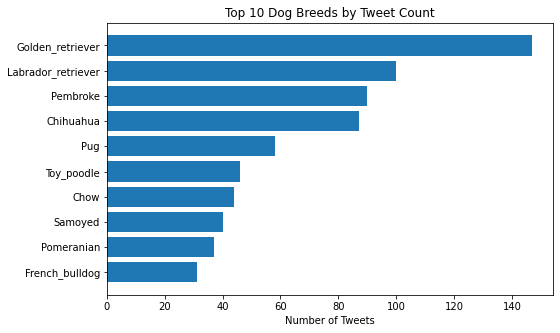

In [70]:
#Visualisation of the top 10 tweeted about breeds
plt.figure(figsize = (8, 5))
plt.barh(breed_count.index,breed_count)
plt.xlabel('Number of Tweets')
plt.title('Top 10 Dog Breeds by Tweet Count')
plt.gca().invert_yaxis()
plt.show();

The golden retreiver is very popular among users

## 4. Is there any relationship between the retweet count and the favorite count ?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


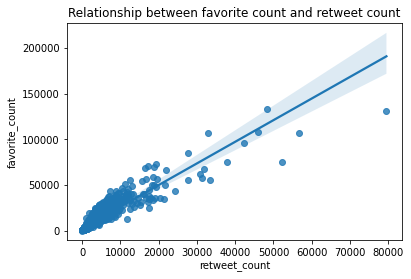

In [71]:
sns.regplot(clean_archive.retweet_count, clean_archive.favorite_count);
plt.title('Relationship between favorite count and retweet count');

There seems to be a positive correlation between retweet and favorite most likely implying that if a tweet has a high favorite value it is most likely going to have a high retweet value too 

## 4. What is the percentage of dogs with ratings of 10 and above

In [79]:
# Percentage of tweets with rating of 10 and up
rating_10up = sum(clean_archive.rating >= 10)
rating_10up_percent = round(rating_10up * 100 / clean_archive.shape[0])

print(f'The total number of ratings that are 10 and above is {rating_10up}')
print(f'The percentage of 10 and up is {rating_10up_percent}%')

The total number of ratings that are 10 and above is 1482
The percentage of 10 and up is 80%


The code above tells us that there are 1482 dogs who scored ratings of 10 and above and this total amounts to about 80% of the whole dataset